In [31]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

import src.utils.file_utils as fu
import src.utils.schema_utils as su
import src.helpers.eda_helpers as eh
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cfg_schema = fu.load_config("schema")
cfg_eda = fu.load_config("eda")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read in raw data file
typed_hmda_data = fu.load_parquet("hmda_2024_typed")
print(typed_hmda_data.shape)

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/interim/hmda_2024_typed.parquet
(8841112, 88)


In [3]:
# Verify target variable is binary
typed_hmda_data["denied_flag"].dtype

bool[pyarrow]

In [4]:
# Verify target variable values are all populated True/False
typed_hmda_data["denied_flag"].value_counts()

denied_flag
False    6693164
True     2147948
Name: count, dtype: int64[pyarrow]

In [5]:
# Target variable class proportions
proportions = typed_hmda_data["denied_flag"].value_counts(normalize=True)
proportions

denied_flag
False    0.75705
True     0.24295
Name: proportion, dtype: double[pyarrow]

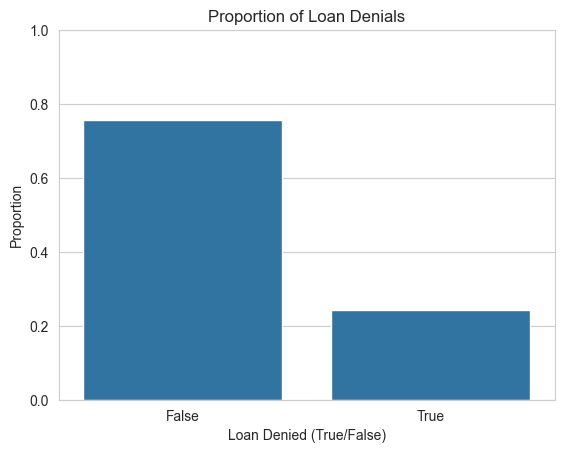

In [6]:
# Convert to DataFrame for seaborn
proportions_df = proportions.reset_index()
proportions_df.columns = ['is_denied', 'proportion']

# Get the output path
graph_output_path = fu.get_path("target_class_balance_graph")

# Create the bar plot
sns.barplot(data=proportions_df, x='is_denied', y='proportion')

plt.title('Proportion of Loan Denials')
plt.ylabel('Proportion')
plt.xlabel('Loan Denied (True/False)')
plt.ylim(0, 1)
plt.savefig(graph_output_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Dataset is imbalanced; may require class weighting or resampling later

In [7]:
# Identify numeric columns needing review due to distributions
numeric_cols = eh.get_numeric_features(typed_hmda_data, cfg_schema)
numeric_cols_to_review = eh.get_numeric_columns_requiring_review(typed_hmda_data, numeric_cols)
numeric_cols_to_review

/Users/c1burns/Documents/UTD/BUAN 6341/project_repo/.venv/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1102: RuntimeWarning: overflow encountered in square
  s = s**2


,skew,kurtosis,outlier_pct
combined_loan_to_value_ratio,2315.116699,inf,NaN
income,2218.461349,5.638447e+06,0.069914
intro_rate_period,1028.857757,1.255138e+06,0.191217
loan_amount,449.069733,4.622267e+05,NaN
loan_term,-1.756328,3.186927e+00,0.139924
multifamily_affordable_units,3.056771,7.548036e+00,0.106593
property_value,279.374908,1.070047e+05,0.064134


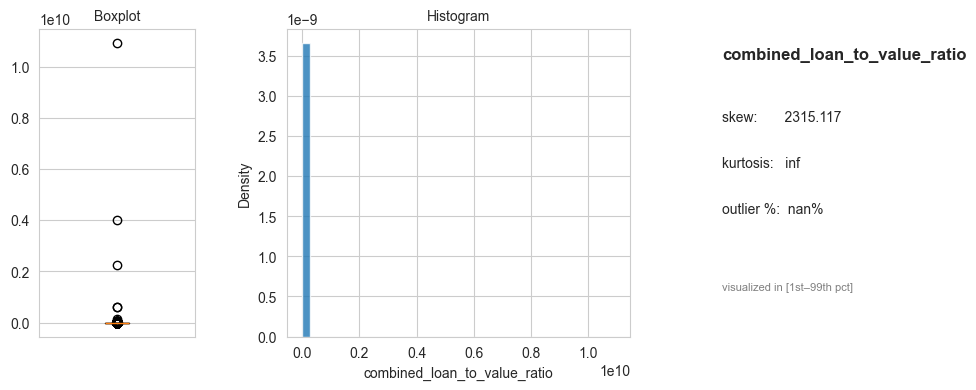

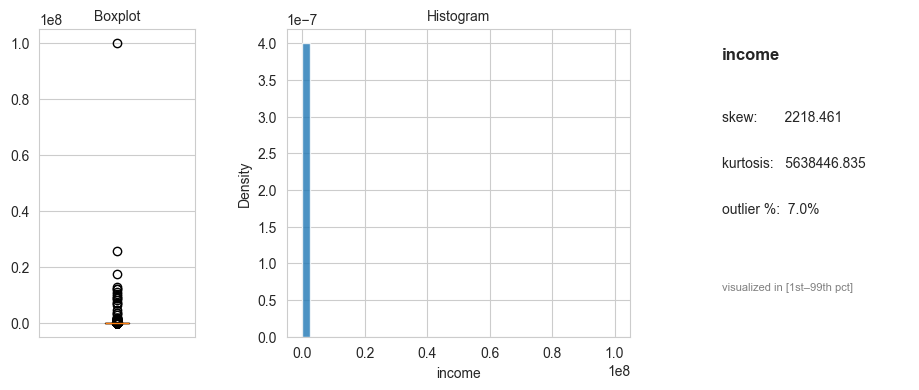

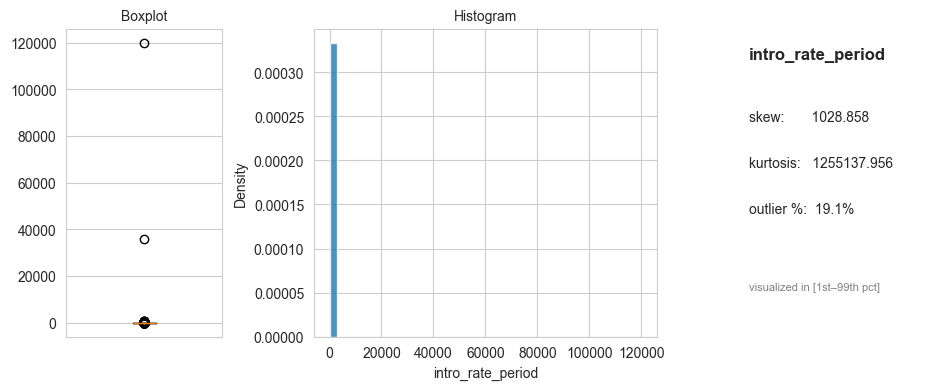

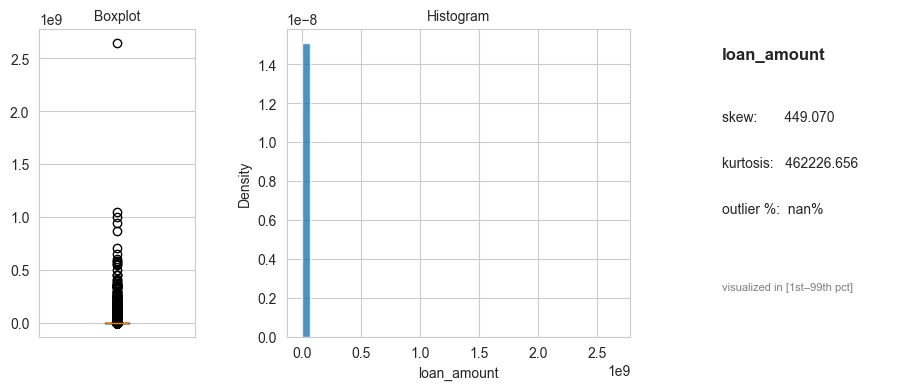

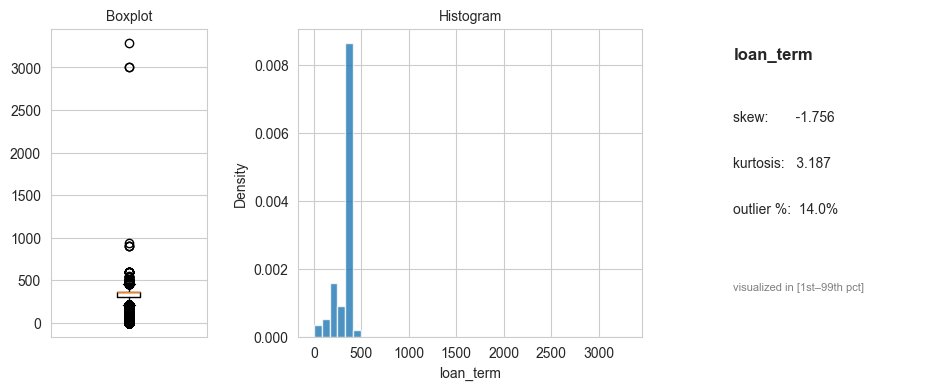

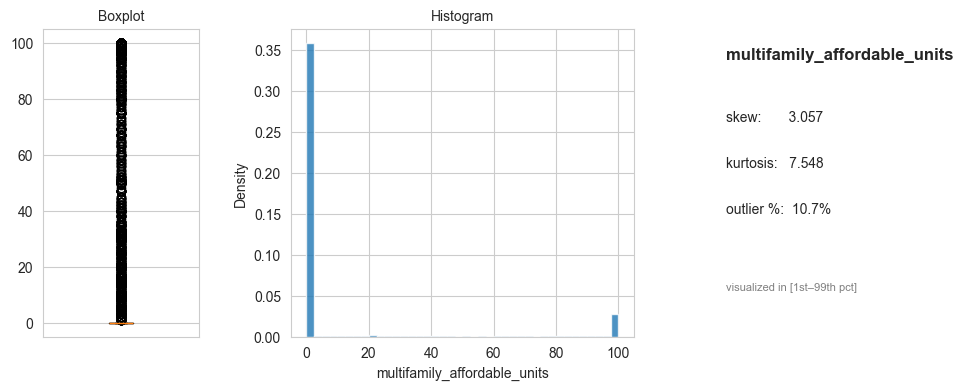

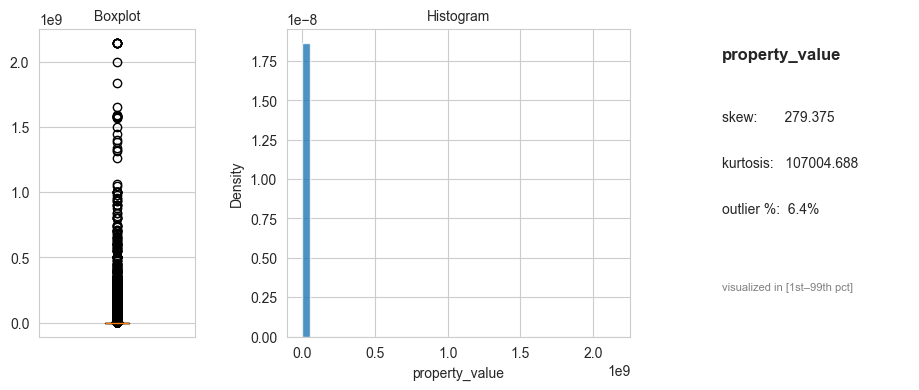

In [8]:
# Plot the numeric features that exceeded a distribution-related threshold
eh.plot_numeric_features(typed_hmda_data, numeric_cols_to_review)

In [8]:
# Income, property_value, loan_amount, and combined_loan_to_value_ratio display significant right skew and outliers as expected.  These features will need to be capped and log transformed prior to modeling.

# intro_rate_period and loan_term have some unreasonably large numbers (>120 months and >480 months respectively) that should be treated as missing values.  They will skew naturally and should be log-transformed prior to modeling.

# multifamily_affordable_units is extremely sparse and naturally right-skewed.  It is so rare that I would recommend either dropping it entirely or collapsing it into a boolean or binned categorical feature rather than retain as numeric.

In [9]:
# Identify categorical columns needing review due to frequency distributions
category_cols = su.get_columns_by_attribute(cfg_schema, "type", "categorical")
category_min_pct_threshold = cfg_eda["eda"]["category_min_pct_threshold"]
eh.get_categorical_columns_requiring_review(typed_hmda_data, category_cols, category_min_pct_threshold)

,feature,n_unique,min_freq,min_pct
0,loan_purpose,6,3514,3.974613e-04
1,state_code,55,48,5.556355e-06
2,county_code,3223,1,1.165532e-07
3,census_tract,83746,1,1.170104e-07
4,applicant_ethnicity_1,9,3605,4.079205e-04
5,co_applicant_ethnicity_1,10,1102,1.246605e-04
6,applicant_race_1,19,425,4.808308e-05
7,applicant_race_2,17,397,8.255938e-04
8,applicant_race_3,17,25,6.398444e-04
9,co_applicant_race_1,20,204,2.307604e-05


In [10]:
# census_tract and county_code are so granular and high-cardinality that they likely aren't useful.  The simple option is to just drop them.  Another possibility is to transform into features like urban/rural, join with external data like unemployment for location, or some sort of continuous hash.

# The race/ethnicity features have been spread across five columns.  These should be transformed using multi-hot encoding.  Each race/ethnicity value should have its own dummy variable and each record will record a boolean for each.

# loan_purpose, applicant_sex, co_applicant_sex, prepayment_penalty_term, total_units, manufactured_home_land_property_interest, co_applicant_credit_scoring_model, and applicant_credit_scoring_model have one or more very rare but legitimate class labels.  Keeping them for now but flagging for attention.  Certain models may want to collapse.

In [11]:
# Identify category classes that perfectly predict denial or approval
eh.identify_perfect_category_classes(typed_hmda_data, category_cols, 'denied_flag')

,feature,class_label,n,denial_rate
0,action_taken,1,6178891,0.0
1,action_taken,2,360855,0.0
2,action_taken,8,153418,0.0
3,action_taken,3,2100646,1.0
4,action_taken,7,47302,1.0
5,census_tract,53033004500,50,0.0


In [12]:
# The action_taken column is really the target class (pre-transformation), so those are irrelevant here.
# census_tract, noted above, should probably be dropped as it is too granular and highly cardinal to be useful.
# Overall, no concerns about perfect category classes

In [13]:
# Identify categorical features where the highest and lowest denial rates per class are more than 15% apart.  These categories display class imbalance and may need intervention in feature engineering or modeling.
eh.identify_categories_with_large_denial_ranges(typed_hmda_data, category_cols, 'denied_flag')

,feature,n_classes,min_rate,max_rate,feature_range
0,action_taken,5,0.000000,1.000000,1.000000
1,county_code,3223,0.000000,1.000000,1.000000
2,census_tract,83892,0.000000,1.000000,1.000000
3,prepayment_penalty_term,36,0.000000,1.000000,1.000000
4,co_applicant_race_5,16,0.130435,1.000000,0.869565
5,applicant_race_4,17,0.122449,0.909091,0.786642
6,initially_payable_to_institution,4,0.133150,0.896916,0.763766
7,applicant_race_5,17,0.000000,0.750000,0.750000
8,co_applicant_race_3,17,0.120370,0.827957,0.707587
9,applicant_credit_scoring_model,15,0.118149,0.752857,0.634708


In [14]:
# Most categorical features display some level of class imbalance.  Special attention should be given during feature engineering and modeling.

In [15]:
# Identify columns with notable missing data
num_na = (
    typed_hmda_data
    .isna()
    .mean()
    .sort_values(ascending=False)
    .to_frame('missing_pct')
)
num_na[num_na['missing_pct'] > 0.01]  # only show >1% missing

,missing_pct
co_applicant_ethnicity_5,0.999996
co_applicant_ethnicity_4,0.999988
applicant_ethnicity_5,0.999988
applicant_ethnicity_4,0.999960
co_applicant_race_5,0.999914
applicant_race_5,0.999787
co_applicant_race_4,0.999766
co_applicant_ethnicity_3,0.999543
applicant_race_4,0.999367
applicant_ethnicity_3,0.998643


In [27]:
# The race/ethnicity columns will be transformed as noted above.
# multifamily_affordable_units will likely be collapsed into a binary or a small set of classes.
# prepayment_penalty_term and intro_rate_term have many missing values because most mortgages don't include them.  Keeping to see if informative.  Could also consider supplementing or replacing by a binary feature.
# Many of the missing values are intentionally empty because not every field must be completed or is applicable with every mortgage loan application.
# income has a sizable number missing.  Add a binary flag for missing income.  Also impute values stratified by loan_type using median income to loan amount ratio.
# property_value has a number missing.  Add a binary flag for missing property value.  Also impute values using the median loan to value ratio and the loan value for the app.
# loan_term missing values are explained by other features such as reverse mortgages and open end lines of credit.  Missing is valid.

In [33]:
# Pearson correlations between numeric features
eh.identify_highly_correlated_numeric_features(typed_hmda_data, numeric_cols, 'denied_flag')

,feature_1,feature_2,corr


In [34]:
# There are no highly correlated numeric features to review.